# Машинное обучение, ММП ВМК МГУ

## Практическое задание 4. Разложение ошибки на смещение и разброс. Градиентный бустинг ~~своими руками~~

### Общая информация

Дата выдачи: 09.12.2019

Мягкий дедлайн: 23:59MSK 22.12.2019

Жесткий дедлайн: 23:59MSK 29.12.2019

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-06-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

В этом задании вам предстоит воспользоваться возможностями bootstraping для оценки смещения и разброса алгоритмов машинного обучения. Делать мы это будем на данных boston. 
Также в задании вам будет предложено пообучать готовые модели градиентного бустинга и CatBoost.

## Часть 1. Bias-Variance Decomposition

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
from sklearn.datasets import load_boston

In [3]:
boston = load_boston()

In [4]:
X = boston["data"]
y = boston["target"]

In [5]:
X.shape, y.shape

((506, 13), (506,))

### Вычисление bias и variance с помощью бутстрапа
На лекции была выведено следующая формула, показывающая, как можно представить ошибку алгоритма регрессии в виде суммы трех компонент:
$$
L(\mu) = 
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] = 
$$
$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ — алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ — мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ — "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
    
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### Приближенное вычисление интегралов
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [6]:
z = np.random.normal(loc=5, scale=3, size=1000)
(z**2).mean()

34.24729834112394

#### Оценивание $\mathbb{E}_{x, y}$
Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка. 

#### Оценивание $\mathbb{E}_X$ с помощью бутстрапа
Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

#### Итоговый алгоритм оценки смещения и разброса алгоритма $a$
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$. 

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$. 

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!

Алгоритм также вкратце описан по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).

__Задание 1. (3 балла)__

Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно. Как обычно, разрешается использовать только один цикл - по выборкам (от 0 до num_runs-1).

In [7]:
from tqdm import tqdm_notebook


def compute_biase_variance(regressor, X, y, num_runs=100):
    """
    :param regressor: sklearn estimator with fit(...) and predict(...) method
    :param X: numpy-array representing training set ob objects, shape [n_obj, n_feat]
    :param y: numpy-array representing target for training objects, shape [n_obj]
    :param num_runs: int, number of samples (s in the description of the algorithm)
    
    :returns: bias (float), variance (float), error (float) 
    each value is computed using bootstrap
    """
    
    predictions = np.zeros((X.shape[0], num_runs))
    predictions[:, :] = np.nan
    error = np.zeros((X.shape[0], num_runs))
    error[:, :] = np.nan
    indexes_all = np.arange(X.shape[0])
    
    for i  in tqdm_notebook(range(num_runs)):
        indexes_train = np.random.choice(indexes_all,
                                      size=X.shape[0],
                                      replace=True)
        indexes_test = np.setdiff1d(indexes_all, indexes_train)
        regressor.fit(X[indexes_train], y[indexes_train])
        
        predictions[indexes_test, i] = regressor.predict(X[indexes_test])
        error[indexes_test, i] = ((predictions[indexes_test, i] - y[indexes_test]) ** 2)

    mean_pred_obj = np.nanmean(predictions, axis=1)
    biase = np.mean((mean_pred_obj - y) ** 2)
    
    variance = np.mean(np.nanvar(predictions, axis=1))
    error = np.mean(np.nanmean(error, axis=1))
    
    return biase, variance, error

**Задание 2. (1 балл)**

Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.


In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


lin_reg = LinearRegression()
dectree_reg = DecisionTreeRegressor()
randfor_reg = RandomForestRegressor()

In [9]:
ans_reg = compute_biase_variance(lin_reg, X, y)
ans_dec = compute_biase_variance(dectree_reg, X, y)
ans_for = compute_biase_variance(randfor_reg, X, y)

print(f'Смещение, разброс, ошибка для линейной регрессии: {ans_reg[0]:6.3f} {ans_reg[1]:6.3f} {ans_reg[2]:6.3f}')
print(f'Смещение, разброс, ошибка для решающего дерева:   {ans_dec[0]:6.3f} {ans_dec[1]:6.3f} {ans_dec[2]:6.3f}')
print(f'Смещение, разброс, ошибка для случайного леса:    {ans_for[0]:6.3f} {ans_for[1]:6.3f} {ans_for[2]:6.3f}')

/home/paniquex/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/home/paniquex/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/home/paniquex/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/home/paniquex/anaconda3/envs/kaggle/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)



Смещение, разброс, ошибка для линейной регрессии: 23.802  0.920 24.722
Смещение, разброс, ошибка для решающего дерева:   10.364 12.502 22.866
Смещение, разброс, ошибка для случайного леса:    10.823  3.291 14.114


Проанализируйте полученный результат. Согласуются ли полученные результаты с теми, что мы обсуждали на семинарах (с комментарием)?

Вспомните обсуждение с лекции о том, во сколько раз в теории бутстрап уменьшает разброс базового алгоритма. Выполняется ли это в ваших экспериментах? Если нет, поясните, почему.

На лекции обсуждалось то, что **бэггинг** в теории уменьшает разброс базового алгоритма в `m` раз (при условии, что алгоритмы мало скоррелированы между собой), где `m` - количество выборок, сформированных с помощью **бутстрапа**.

__Your answer here:__ из полученных результатов видно, что:

1. Линейная регрессия обладает наибольшим смещением и наименьшим разбросом среди 3 выбранных алгоритмов (что является логичным, так как большое смещение и маленький разброс говорят о простоте модели).
1. Смещения решающего дерева и случайного леса практически не отличаются, так как из лекций известно, что бэггинг не изменяет смещение.
1. Видно, что разброс случайного леса сильно уменьшился относительно решающего дерева. Этот факт частично подтверждает теоретическую часть, рассказанную на лекциях: бэггинг уменьшает разброс в `m` раз (при условии, что алгоритмы очень слабо скоррелированы между собой), где `m` - количество выборок, сформированных с помощью бутстрапа. В данном случае `m = 10`, так как по умолчанию в `RandomForestRegressor` значение `n_estimators = 10`. Мне кажется, что рассхождение возможно из-за того, что в при построении деревьев в случайном лесе деревья оказываются скоррелированы между собой.





### Визуализация предсказаний базовых алгоритмов бэггинга

В материалах лекций можно найти изображение, похожее на мишень - визуализация алгоритмов с разным смещением и разным разбросом. В центре "мишени" - правильный ответ, а "попадания" - предсказания алгоритмов, обученных по разным выборкам. Построим похожее изображение на наших данных для трех алгоритмов. Наши "мишени" будут одномерными, потому что мы решаем задачу одномерной регрессии.

__Задание 3. (2 балла)__

Реализуйте фукнцию plot_predictions. Она должна выполнять следующие действия:
1. Случайно выбрать num_test_objects пар объект-целевая переменная из выборки X, y. Получится две выборки: маленькая X_test, y_test (выбранные тестовые объекты) и X_train, y_train (остальные объекты).
1. Сгенерировать num_runs выборок методом бутстарапа из X_train, y_train. На каждой выборке обучить алгоритм regressor и сделать предсказания для X_test.
1. Нарисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта надо отметить одним цветом все предсказания для него, а также черным цветом отметить правильный ответ.
1. Подпишите оси и название графика (аргумент title).

In [10]:
import random
random.seed(13)
np.random.seed(13)

In [11]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


def plot_predictions(regressor, X, y, num_runs=5000, num_test_objects=15, title="", ax=None):
    """
    plot graphics described above
    """
    
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=num_test_objects,
                                                        random_state=13)
    predictions = np.zeros((num_test_objects, num_runs))
    all_indexes = np.arange(X_train.shape[0])
    for i in range(num_runs):
        indexes_bs = np.random.choice(all_indexes,
                                      size=X_train.shape[0],
                                      replace=True)
        
        regressor.fit(X_train[indexes_bs], y_train[indexes_bs])
        predictions[:, i] = regressor.predict(X_test)
        if ax is None:
            plt.scatter(np.arange(X_test.shape[0]), predictions[:, i], color='black', label='y_preds')
        else:
            line_pred = ax.scatter(np.arange(X_test.shape[0]), predictions[:, i], color='black', label='y_preds')
    if ax is None:
        plt.scatter(np.arange(X_test.shape[0]), y_test, color='red', label='y_true')
    else:
        line_true = ax.scatter(np.arange(X_test.shape[0]), y_test, color='red', label='y_true')
        ax.title.set_text(title)
        ax.set_xticks(np.arange(num_test_objects))
        ax.set_xlabel('Номер объекта из теста')
    return line_true, line_pred
    
    
    

Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса. Нарисуйте три графика в строчку (это можно сделать с помощью plt.subplot) с одинаковой осью ординат (это важно для понимания масштаба разброса у разных алгоритмов):

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

lin_reg = LinearRegression()
dectree_reg = DecisionTreeRegressor()
randforest_reg = RandomForestRegressor(20)

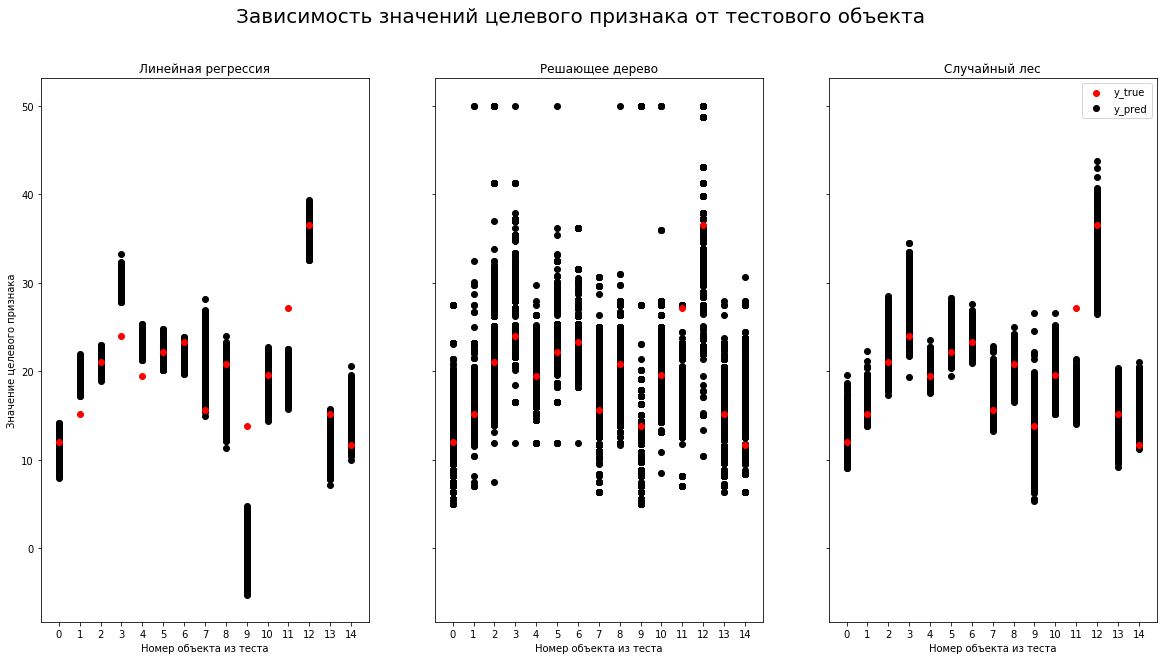

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(20, 10), sharey=True)
plot_predictions(lin_reg, X, y, ax=axs[0], title='Линейная регрессия')
plot_predictions(dectree_reg, X, y, ax=axs[1], title='Решающее дерево')
l_true, l_pred = plot_predictions(randforest_reg, X, y, ax=axs[2], title='Случайный лес')
axs[0].set_ylabel('Значение целевого признака')

fig.suptitle('Зависимость значений целевого признака от тестового объекта', fontsize=20)
plt.legend([l_true, l_pred],['y_true', 'y_pred'])
plt.show()

Для каждого графика прокомментируйте, как он характеризует смещение и разброс соответствующего алгоритма.

**Your answer here:**
по данным графикам видно, что выполняются выводы из задания номер 2:

1. Линейная регрессия обладает наибольшим смещением и наименьшим разбросом среди 3 выбранных алгоритмов (что является логичным, так как большое смещение и маленький разброс говорят о простоте модели).
1. Рещающее дерево обладает достаточно большим разбросом, так как эта модель очень склонна к переобучению (`max_depth = None` по умолчанию, что говорит о неограниченности глубины дерева).
1. Смещения решающего дерева и случайного леса практически не отличаются, так как из лекций известно, что бэггинг не изменяет смещение.
1. Видно, что разброс случайного леса сильно уменьшился относительно решающего дерева. Этот факт частично подтверждает теоретическую часть, рассказанную на лекциях: бэггинг уменьшает разброс в `m` раз (при условии, что алгоритмы очень слабо скоррелированы между собой), где `m` - количество выборок, сформированных с помощью бутстрапа. В данном случае `m = 10`, так как по умолчанию в `RandomForestRegressor` значение `n_estimators = 10`. Мне кажется, что рассхождение возможно из-за того, что в при построении деревьев в случайном лесе деревья оказываются скоррелированы между собой.




### Часть 2. Градиентный бустинг

**Задание 4 (1 балл)**

Мы будем использовать данные из [соревнования](https://www.kaggle.com/t/b710e05dc0bd424995ca94da5b639869). 
* Загрузите таблицу application_train.csv;
* Запишите в Y столбец с целевой переменной (TARGET);
* Удалите ненужные столбцы (для этого воспользуйтесь описанием);
* Определите тип столбцов и заполните пропуски - стратегия произвольная;
* Разбейте выборку в соотношении 70:30 с random_state=0.

Так как в данных имеется значительный дисбаланс классов, в качестве метрики качества везде будем использовать площадь под precision-recall кривой (AUC-PR).

In [14]:
train_data = pd.read_csv('./data/application_train.csv')

Y = train_data['TARGET']
train_data.drop(columns='TARGET', inplace=True)

 Какие признаки можно удалить?
 1. Удалим признак `SK_ID_CURR`, так уникальный идентификатор не несет никакой информации о целевом признаке
 1. Удалим признаки `WEEKDAY_APPR_PROCESS_START` и `HOUR_APPR_PROCESS_START`, так как они отвечают за день недели и время подачи заявки на кредит.

In [15]:
train_data.drop(columns=['SK_ID_CURR',
                         'WEEKDAY_APPR_PROCESS_START',
                         'HOUR_APPR_PROCESS_START'], inplace=True)


In [16]:
train_data.shape

(215257, 118)

~~Будем считать, что признак категориальный, если количество уникальных значений 2 <= n <= 30~~

In [17]:
#n_uniq = 30
#cat_features = []


#for col in train_data.columns:
#    uniq_amount = len(train_data[col].unique())
#    if (uniq_amount <= n_uniq) & (uniq_amount >= 2):
#        cat_features.append(col)  

Будем считать, что признак категориальный, если его тип = 'object'.

In [18]:
%%time
cat_features = []


for col in train_data.columns:
    if train_data[col].dtype == 'object':
        cat_features.append(col)     

CPU times: user 3.53 ms, sys: 0 ns, total: 3.53 ms
Wall time: 3.54 ms


Для вещественных признаков заполним пропуски средним по данному признаку.

In [19]:
numerical_features = set(train_data.columns) - set(cat_features)


for numerical_col in numerical_features:
    mean_col = np.mean(train_data[numerical_col])
    train_data[numerical_col].fillna(mean_col, inplace=True)

Разобьем выборку в соотношении 70:30 с random_state=0.

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_data, Y, test_size=0.3, random_state=0)

**Задание 5 (1 балл)**

Обучите реализации градиентного бустинга LightGBM и Catboost на вещественных признаках без подбора параметров. **Почему получилась заметная разница в качестве?**

В этом и последующих экспериментах необходимо измерять время обучения моделей.

In [21]:
from sklearn.metrics import average_precision_score

In [22]:
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [23]:
%%time


lgbm_model = LGBMClassifier(n_jobs=-1)
lgbm_model.fit(X_train[numerical_features], y_train)
lgbm_preds = lgbm_model.predict_proba(X_test[numerical_features])[:, 1]

CPU times: user 30.6 s, sys: 869 ms, total: 31.5 s
Wall time: 1.16 s


In [24]:
%%time


catboost_model = CatBoostClassifier(verbose=0, thread_count=16)
catboost_model.fit(X_train[numerical_features], y_train)
catboost_preds = catboost_model.predict_proba(X_test[numerical_features])[:, 1]

CPU times: user 5min 49s, sys: 6.25 s, total: 5min 55s
Wall time: 22.6 s


In [25]:
print(f'LGBM PR-AUC: {average_precision_score(y_test, lgbm_preds)}')
print(f'CatBoost PR-AUC: {average_precision_score(y_test, catboost_preds)}')

LGBM PR-AUC: 0.2397493585281123
CatBoost PR-AUC: 0.23844508531957803


**Your answer here:** Разница получилась совсем незначительной, хоть и Catboost обучался почти в 21 раз дольше.. LGBM показал качество хуже, так как, возможно, для этих данных "жадный алгоритм", встроенный в реализации LGBM, построения композиции дает не самый лучший результат. Еще одна причина: мы совсем не использовали категориальные признаки, а они как раз являются ключевой особенностью библиотеки Catboost.

Проведем ещё немного предобработки: 
1. Удалим все признаки, в которых $количество\spaceпропусков >= 0.6 * (количество\spaceвсех\spaceзначений)$

In [26]:
train_data = pd.read_csv('./data/application_train.csv')

Y = train_data['TARGET']
train_data.drop(columns='TARGET', inplace=True)

train_data.drop(columns=['SK_ID_CURR',
                         'WEEKDAY_APPR_PROCESS_START',
                         'HOUR_APPR_PROCESS_START'], inplace=True)

In [27]:
print('Признаки, которые содержат более 60% nan-значений:')
for col in train_data.columns:
    if (np.sum(train_data.isna()[col]) / len(train_data)) >= 0.6:
        print(col, f', Процент nan-значений: {100 * np.sum(train_data.isna()[col]) / len(train_data):.2f}%')
        train_data.drop(columns=col, inplace=True)

Признаки, которые содержат более 60% nan-значений:
OWN_CAR_AGE , Процент nan-значений: 65.89%
YEARS_BUILD_AVG , Процент nan-значений: 66.50%
COMMONAREA_AVG , Процент nan-значений: 69.86%
FLOORSMIN_AVG , Процент nan-значений: 67.82%
LIVINGAPARTMENTS_AVG , Процент nan-значений: 68.33%
NONLIVINGAPARTMENTS_AVG , Процент nan-значений: 69.41%
YEARS_BUILD_MODE , Процент nan-значений: 66.50%
COMMONAREA_MODE , Процент nan-значений: 69.86%
FLOORSMIN_MODE , Процент nan-значений: 67.82%
LIVINGAPARTMENTS_MODE , Процент nan-значений: 68.33%
NONLIVINGAPARTMENTS_MODE , Процент nan-значений: 69.41%
YEARS_BUILD_MEDI , Процент nan-значений: 66.50%
COMMONAREA_MEDI , Процент nan-значений: 69.86%
FLOORSMIN_MEDI , Процент nan-значений: 67.82%
LIVINGAPARTMENTS_MEDI , Процент nan-значений: 68.33%
NONLIVINGAPARTMENTS_MEDI , Процент nan-значений: 69.41%
FONDKAPREMONT_MODE , Процент nan-значений: 68.38%


In [28]:
%%time

cat_features = []


for col in train_data.columns:
    if train_data[col].dtype == 'object':
        cat_features.append(col)

CPU times: user 31.5 ms, sys: 523 µs, total: 32 ms
Wall time: 2 ms


In [29]:
numerical_features = set(train_data.columns) - set(cat_features)


for numerical_col in numerical_features:
    mean_col = np.mean(train_data[numerical_col])
    train_data[numerical_col].fillna(mean_col, inplace=True)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(train_data, Y, test_size=0.3, random_state=0)

Обучим модели только на вещественных признаках и посмотрим на результаты:

In [31]:
%%time


lgbm_model = LGBMClassifier(n_jobs=-1)
lgbm_model.fit(X_train[numerical_features], y_train)
lgbm_preds = lgbm_model.predict_proba(X_test[numerical_features])[:, 1]

CPU times: user 26.7 s, sys: 675 ms, total: 27.4 s
Wall time: 979 ms


In [32]:
%%time


catboost_model = CatBoostClassifier(verbose=0, thread_count=16)
catboost_model.fit(X_train[numerical_features], y_train)
catboost_preds = catboost_model.predict_proba(X_test[numerical_features])[:, 1]

CPU times: user 5min 24s, sys: 5.5 s, total: 5min 29s
Wall time: 20.8 s


In [33]:
print(f'LGBM PR-AUC: {average_precision_score(y_test, lgbm_preds)}')
print(f'CatBoost PR-AUC: {average_precision_score(y_test, catboost_preds)}')

LGBM PR-AUC: 0.23529529795703574
CatBoost PR-AUC: 0.23618625167132357


Теперь `CatBoostClassifier` стал лучше, чем `LGBMClassifier`. Интересно, что выбрасывание столбцов с большим количеством nan-значений сильнее ухудшило результат `LGBMClassifier`, чем `CatBoostClassifier`. Это говорит о стабильности алгоритма `CatBoostClassifier`.

 Ради эксперимента попробуем использовать еще и категориальные признаки вместе с вещественными:
 1. Сначала попробуем самостоятельно закодировать их с помощью one-hot кодирования.
 1. Затем воспользуемся встроенными методами обработки категориальных признаков.

In [34]:
def one_hot_encoding(data, cat_columns):
    data_ohe = data.copy()
    for cat_column in cat_columns:
        unique_values = data_ohe[cat_column].unique()
        for unique_value in unique_values:
            data_ohe[cat_column + '_' + str(unique_value)] = data_ohe[cat_column] == unique_value
            data_ohe[cat_column + '_' + str(unique_value)] =\
                data_ohe[cat_column + '_' + str(unique_value)].map({True: 1, False: 0})
    return data_ohe.drop(columns=cat_columns)

Для категориальных признаков заполним пропуски самым популярным значением.

In [35]:
for cat_col in cat_features:
    nan_mask = train_data[cat_col].isna()
    train_data.loc[nan_mask, cat_col] = train_data[cat_col].value_counts().index[0]

In [36]:
%%time
train_data_ohe = one_hot_encoding(train_data, cat_features)
train_data_ohe.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in train_data_ohe.columns]
## чтобы LGBM не ругался на название признаков

CPU times: user 10.7 s, sys: 915 ms, total: 11.6 s
Wall time: 2.7 s


Разобьем выборку в соотношении 70:30 с random_state=0.

In [37]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_data_ohe, Y, test_size=0.3, random_state=0)

In [38]:
%%time


lgbm_model = LGBMClassifier(n_jobs=-1)
lgbm_model.fit(X_train, y_train)
lgbm_preds = lgbm_model.predict_proba(X_test)[:, 1]

CPU times: user 34.4 s, sys: 1.51 s, total: 36 s
Wall time: 1.37 s


In [39]:
%%time


catboost_model = CatBoostClassifier(verbose=0, thread_count=16)
catboost_model.fit(X_train, y_train)
catboost_preds = catboost_model.predict_proba(X_test)[:, 1]

CPU times: user 5min 36s, sys: 6.02 s, total: 5min 42s
Wall time: 21.7 s


In [40]:
print(f'LGBM PR-AUC: {average_precision_score(y_test, lgbm_preds)}')
print(f'CatBoost PR-AUC: {average_precision_score(y_test, catboost_preds)}')

LGBM PR-AUC: 0.24238566035191744
CatBoost PR-AUC: 0.24762594465394733


`CatBoostClassifier` стал превосходить по качеству `LGBMClassifier`. Это и ожидалось. 

### Рассмотрим качество при встроенной обработке категориальных признаков:

In [41]:
## Опять же для того, чтобы LGBMClassifier заработал

train_data_cat = train_data.copy()
for c in train_data_cat.columns:
    col_type = train_data_cat[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        train_data_cat[c] = train_data_cat[c].astype('category')

In [42]:
X_train, X_test, y_train, y_test = train_test_split(train_data_cat, Y, test_size=0.3, random_state=0)

In [43]:
%%time


lgbm_model = LGBMClassifier(n_jobs=-1)
lgbm_model.fit(X_train, y_train)
lgbm_preds = lgbm_model.predict_proba(X_test)[:, 1]

CPU times: user 30.1 s, sys: 1.03 s, total: 31.2 s
Wall time: 1.12 s


In [44]:
%%time


catboost_model = CatBoostClassifier(verbose=0, thread_count=16, cat_features=cat_features,
                                   model_size_reg=0,
                                   combinations_ctr='Borders:TargetBorderType=GreedyLogSum')
catboost_model.fit(X_train, y_train)
catboost_preds = catboost_model.predict_proba(X_test)[:, 1]

Change of combinations ctrs will not affect simple ctrs


CPU times: user 13min 3s, sys: 36.8 s, total: 13min 40s
Wall time: 52.8 s


In [45]:
print(f'LGBM PR-AUC: {average_precision_score(y_test, lgbm_preds)}')
print(f'CatBoost PR-AUC: {average_precision_score(y_test, catboost_preds)}')

LGBM PR-AUC: 0.24300801616126183
CatBoost PR-AUC: 0.24803399121177794


Видно, что встроенная обработка категориальных признаков работает лучше, чем обычное one-hot кодирование (что неудивительно). При этом прирост качества у `CatBoostClassifier` больше (относительно one-hot кодирования), чем у `LGBMClassifier`, но не стоит забывать и о времени работы: время работы `CatBoostClassifier` увеличилось почти в **3 раза**, а у `LGBMClassifier` практически не изменилось.

__Задание 6. (2 балла)__

Подберите оптимальные с точки зрения метрики качества параметры алгоритмов, изменяя:

* глубину деревьев;
* количество деревьев;
* темп обучения;
* оптимизируемый функционал.

Масштаб значений предлагается посмотреть в [семинаре](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/seminars/sem10-gbm.ipynb) про библиотеки.

**Проанализируйте соотношения глубины и количества деревьев в зависимости от алгоритма.** 

**Если на перебор гиперпараметров уходит много времени, то переберите значениях каких-нибудь 1-2 гиперпараметров, а не всех предложенных 4**

Произведем аналогичную предобработку, которая раньше давала качество:
1. CatBoost PR-AUC: 0.2384
1. LGBM PR-AUC: 0.2396


In [46]:
train_data = pd.read_csv('./data/application_train.csv')

Y = train_data['TARGET']
train_data.drop(columns='TARGET', inplace=True)

 Какие признаки можно удалить?
 1. Удалим признак `SK_ID_CURR`, так уникальный идентификатор не несет никакой информации о целевом признаке
 1. Удалим признаки `WEEKDAY_APPR_PROCESS_START` и `HOUR_APPR_PROCESS_START`, так как они отвечают за день недели и время подачи заявки на кредит.

In [47]:
train_data.drop(columns=['SK_ID_CURR',
                         'WEEKDAY_APPR_PROCESS_START',
                         'HOUR_APPR_PROCESS_START'], inplace=True)


In [48]:
train_data.shape

(215257, 118)

~~Будем считать, что признак категориальный, если количество уникальных значений 2 <= n <= 30~~

In [49]:
#n_uniq = 30
#cat_features = []


#for col in train_data.columns:
#    uniq_amount = len(train_data[col].unique())
#    if (uniq_amount <= n_uniq) & (uniq_amount >= 2):
#        cat_features.append(col)  

Будем считать, что признак категориальный, если его тип = 'object'.

In [50]:
%%time
cat_features = []


for col in train_data.columns:
    if train_data[col].dtype == 'object':
        cat_features.append(col)     

CPU times: user 4.11 ms, sys: 3 µs, total: 4.11 ms
Wall time: 4.12 ms


Для вещественных признаков заполним пропуски средним по данному признаку.

In [51]:
numerical_features = set(train_data.columns) - set(cat_features)


for numerical_col in numerical_features:
    mean_col = np.mean(train_data[numerical_col])
    train_data[numerical_col].fillna(mean_col, inplace=True)

Разобьем выборку в соотношении 70:30 с random_state=0.

In [52]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_data, Y, test_size=0.3, random_state=0)

In [53]:
%%time

import time

from tqdm import tqdm_notebook

max_depth_list = list(range(1, 10, 1)) + list(range(10, 16, 2))
tree_amount_list = [1, 5, 10, 100, 300, 500, 700]
learning_rate_list = [1e-3, 1e-2, 1e-1, 1]
loss_func_list = ['Logloss'] # Так как это задача бинарной классификации,
                             # то обе библиотеки предоставляют единственный вариант

catboost_logger = {'max_depth_list': [],
                   'tree_amount_list': [],
                   'learning_rate_list': [],
                   'loss_func_list': [],
                   'AUC-PR_list': [],
                   'estimated_time': []
                  }

i = 0

for max_depth in tqdm_notebook(max_depth_list):
    for tree_amount in tree_amount_list:
        for lr in learning_rate_list:
            for loss_func in loss_func_list:
                start_time = time.time()
                catboost_model = CatBoostClassifier(max_depth=max_depth, n_estimators=tree_amount,
                                            learning_rate=lr, objective=loss_func,
                                             task_type='GPU', verbose=0, thread_count=-1)
                
                catboost_model.fit(X_train[numerical_features], y_train)
                preds = catboost_model.predict_proba(X_test[numerical_features])[:, 1]
                catboost_logger['AUC-PR_list'].append(average_precision_score(y_test, preds))
                catboost_logger['max_depth_list'].append(max_depth)
                catboost_logger['tree_amount_list'].append(tree_amount)
                catboost_logger['learning_rate_list'].append(lr)
                catboost_logger['loss_func_list'].append(loss_func)
                catboost_logger['estimated_time'].append(time.time() - start_time)
                
                i += 1

/home/paniquex/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



CPU times: user 1h 11s, sys: 21min 4s, total: 1h 21min 16s
Wall time: 34min 11s


In [54]:
import pickle

with open('catboost_logger.pkl', 'wb') as file:
    pickle.dump(catboost_logger, file)

In [55]:
%%time

from tqdm import tqdm_notebook

max_depth_list = list(range(1, 10, 1)) + list(range(10, 20, 2))
tree_amount_list = [1, 5, 10, 100, 300, 500, 700]
learning_rate_list = [1e-3, 1e-2, 1e-1, 1]
loss_func_list = ['binary'] # Так как это задача бинарной классификации,
                             # то обе библиотеки предоставляют единственный вариант

lgbm_logger = {'max_depth_list': [],
                   'tree_amount_list': [],
                   'learning_rate_list': [],
                   'loss_func_list': [],
                   'AUC-PR_list': [],
                   'estimated_time': []
                  }

i = 0

for max_depth in tqdm_notebook(max_depth_list):
    for tree_amount in tree_amount_list:
        for lr in learning_rate_list:
            for loss_func in loss_func_list:
                start_time = time.time()
                lgbm_model = LGBMClassifier(max_depth=max_depth, n_estimators=tree_amount,
                                            learning_rate=lr, objective=loss_func,
                                             n_jobs=-1, device='CPU')
                
                lgbm_model.fit(X_train[numerical_features], y_train)
                preds = lgbm_model.predict_proba(X_test[numerical_features])[:, 1]
                lgbm_logger['AUC-PR_list'].append(average_precision_score(y_test, preds))
                lgbm_logger['max_depth_list'].append(max_depth)
                lgbm_logger['tree_amount_list'].append(tree_amount)
                lgbm_logger['learning_rate_list'].append(lr)
                lgbm_logger['loss_func_list'].append(loss_func)
                lgbm_logger['estimated_time'].append(time.time() - start_time)
                i += 1

/home/paniquex/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



CPU times: user 5h 33min 32s, sys: 7min 26s, total: 5h 40min 58s
Wall time: 10min 59s


In [56]:
import pickle

with open('lgbm_logger.pkl', 'wb') as file:
    pickle.dump(lgbm_logger, file)

In [57]:
best_score_idx_ctb = np.argmax(catboost_logger['AUC-PR_list'])
best_score_idx_lgb = np.argmax(lgbm_logger['AUC-PR_list'])

**Your answer here:**

In [58]:
print(f'''Оптимальные параметры для CatBoostClassifier: 
      Максимальная глубина деревьев:        {catboost_logger['max_depth_list'][best_score_idx_ctb]:6}
      Количество деревьев:                  {catboost_logger['tree_amount_list'][best_score_idx_ctb]:6}
      Learning rate:                        {catboost_logger['learning_rate_list'][best_score_idx_ctb]:6}
      Затраченное время (GPU):              {catboost_logger['estimated_time'][best_score_idx_ctb]:6.2f} с.
      Значение метрики:                    {catboost_logger['AUC-PR_list'][best_score_idx_ctb]:5.5f}''')

Оптимальные параметры для CatBoostClassifier: 
      Максимальная глубина деревьев:             3
      Количество деревьев:                     500
      Learning rate:                           0.1
      Затраченное время (GPU):                1.56 с.
      Значение метрики:                    0.24370


Так как для ускорения работы `CatBoostClassifier` обучение производилось на GPU, то время сравнивать сложно. Проведем еще раз обучение алгоритма CatBoostClassifier с лучшими параметрами и измерим время:

In [59]:
catboost_model = CatBoostClassifier(max_depth=3, n_estimators=700,
                                            learning_rate=0.1, objective='Logloss',
                                             task_type='CPU', verbose=0, thread_count=-1)

start_time = time.time()
catboost_model.fit(X_train[numerical_features], y_train)
catboost_logger['estimated_time'][best_score_idx_ctb] = time.time() - start_time

In [60]:
print(f'''Оптимальные параметры для CatBoostClassifier: 
      Максимальная глубина деревьев:        {catboost_logger['max_depth_list'][best_score_idx_ctb]:6}
      Количество деревьев:                  {catboost_logger['tree_amount_list'][best_score_idx_ctb]:6}
      Learning rate:                        {catboost_logger['learning_rate_list'][best_score_idx_ctb]:6}
      Затраченное время (CPU):              {catboost_logger['estimated_time'][best_score_idx_ctb]:6.2f} с.
      Значение метрики:                     {catboost_logger['AUC-PR_list'][best_score_idx_ctb]:5.5f}''')

Оптимальные параметры для CatBoostClassifier: 
      Максимальная глубина деревьев:             3
      Количество деревьев:                     500
      Learning rate:                           0.1
      Затраченное время (CPU):               12.98 с.
      Значение метрики:                     0.24370


In [61]:
print(f'''Оптимальные параметры для LGBMClassifier: 
      Максимальная глубина деревьев:        {lgbm_logger['max_depth_list'][best_score_idx_lgb]:6}
      Количество деревьев:                  {lgbm_logger['tree_amount_list'][best_score_idx_lgb]:6}
      Learning rate:                        {lgbm_logger['learning_rate_list'][best_score_idx_lgb]:6}
      Затраченное время (CPU):              {lgbm_logger['estimated_time'][best_score_idx_lgb]:6.2f} с.
      Значение метрики:                    {lgbm_logger['AUC-PR_list'][best_score_idx_lgb]:5.5f}''')

Оптимальные параметры для LGBMClassifier: 
      Максимальная глубина деревьев:             3
      Количество деревьев:                     300
      Learning rate:                           0.1
      Затраченное время (CPU):                1.37 с.
      Значение метрики:                    0.24335


Из данных результатов видно, что для `CatBoostClassifier` оптимальная глубина деревьев на 1 больше, чем оптимальная глубина для `LGBMClassifier`. При этом количество деревьев, которые нужны для оптимального качества, более чем полтора раза больше у `CatBoostClassifier`, чем у `LGBMClassifier`.

Хоть и качество у `CatBoostClassifier` оказалось выше, обучался данный алгоритм почти в 10 раз дольше. На лекции говорилось, что скорость работы `LGBMClassifier` достигается за счет группировки разреженных признаков с маленьким пересечением ненулевых значений в один признак и за счет акцентирования основного внимания на объектах, имеющих большие градиенты.

Ясно, что простой перебор по сетке значений параметров занимает огромное количество времени, поэтому воспользуемся библиотекой `bayes_opt`, рассмотренную на одном из семинаров по практикуму, для ускорения поиска:

In [62]:
from bayes_opt import BayesianOptimization

In [90]:
def catboost_bayesian(max_depth,
                      n_estimators,
                      lr,
                      ):
    max_depth = int(max_depth)
    n_estimators = int(n_estimators)
    model = CatBoostClassifier(max_depth=max_depth, n_estimators=n_estimators,
                               learning_rate=lr, objective='Logloss',
                               task_type='GPU', verbose=0, thread_count=16)
    model.fit(X_train[numerical_features], y_train)

    return average_precision_score(y_test, model.predict_proba(X_test[numerical_features])[:, 1])

In [91]:
bounds_cat = {
    'max_depth': (1, 16),
    'n_estimators': (1, 1000),
    'lr': (1e-5, 1),
}

cat_BO = BayesianOptimization(catboost_bayesian, bounds_cat, random_state=13 * 2)

In [92]:
%%time
import warnings


with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    cat_BO.maximize(init_points=10, n_iter=10, acq='ucb')

|   iter    |  target   |    lr     | max_depth | n_esti... |
-------------------------------------------------------------
|  1        |  0.1858   |  0.3079   |  8.791    |  768.5    |
|  2        |  0.1524   |  0.7892   |  14.06    |  188.7    |
|  3        |  0.1936   |  0.2695   |  8.443    |  739.4    |
|  4        |  0.2424   |  0.195    |  3.696    |  539.3    |
|  5        |  0.1764   |  0.2828   |  12.41    |  270.4    |
|  6        |  0.1837   |  0.2935   |  15.44    |  913.3    |
|  7        |  0.1655   |  0.5682   |  8.282    |  654.1    |
|  8        |  0.1593   |  0.5366   |  15.94    |  142.8    |
|  9        |  0.1509   |  0.9753   |  10.29    |  720.8    |
|  10       |  0.1779   |  0.2951   |  10.0     |  750.9    |
|  11       |  0.08166  |  1.0      |  1.0      |  1.0      |
|  12       |  0.1824   |  1e-05    |  1.0      |  1e+03    |
|  13       |  0.1807   |  1e-05    |  1.0      |  408.4    |
|  14       |  0.182    |  1e-05    |  1.0      |  876.3    |
|  15   

In [93]:
def lgb_bayesian(max_depth,
                      n_estimators,
                      lr,
                      ):
    max_depth = int(max_depth)
    n_estimators = int(n_estimators)
    model = LGBMClassifier(max_depth=max_depth, n_estimators=n_estimators,
                           learning_rate=lr, objective=loss_func,
                           n_jobs=16, device='CPU')
    model.fit(X_train[numerical_features], y_train)

    return average_precision_score(y_test, model.predict_proba(X_test[numerical_features])[:, 1])

In [94]:
bounds_lgbm = {
    'max_depth': (1, 16),
    'n_estimators': (1, 1000),
    'lr': (1e-5, 1),
}


lgbm_BO = BayesianOptimization(lgb_bayesian, bounds_lgbm, random_state=13 * 2)

In [95]:
%%time

with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    lgbm_BO.maximize(init_points=20, n_iter=20)

|   iter    |  target   |    lr     | max_depth | n_esti... |
-------------------------------------------------------------
|  1        |  0.1864   |  0.3079   |  8.791    |  768.5    |
|  2        |  0.1651   |  0.7892   |  14.06    |  188.7    |
|  3        |  0.2006   |  0.2695   |  8.443    |  739.4    |
|  4        |  0.2327   |  0.195    |  3.696    |  539.3    |
|  5        |  0.1959   |  0.2828   |  12.41    |  270.4    |
|  6        |  0.1845   |  0.2935   |  15.44    |  913.3    |
|  7        |  0.1468   |  0.5682   |  8.282    |  654.1    |
|  8        |  0.165    |  0.5366   |  15.94    |  142.8    |
|  9        |  0.1401   |  0.9753   |  10.29    |  720.8    |
|  10       |  0.1836   |  0.2951   |  10.0     |  750.9    |
|  11       |  0.1461   |  0.6414   |  14.85    |  888.8    |
|  12       |  0.1563   |  0.6447   |  5.435    |  682.9    |
|  13       |  0.2377   |  0.277    |  2.896    |  570.3    |
|  14       |  0.1705   |  0.4091   |  9.406    |  854.5    |
|  15   

In [100]:
print(f'''Оптимальные параметры для CatBoostClassifier: 
      Максимальная глубина деревьев:        {int(cat_BO.max['params']['max_depth']):6}
      Количество деревьев:                  {int(cat_BO.max['params']['n_estimators']):6}
      Learning rate:                        {cat_BO.max['params']['lr']:1.5f}
      Значение метрики:                     {cat_BO.max['target']:2.5f}''')

Оптимальные параметры для CatBoostClassifier: 
      Максимальная глубина деревьев:             3
      Количество деревьев:                     539
      Learning rate:                        0.19496
      Значение метрики:                     0.24244


In [101]:
print(f'''Оптимальные параметры для LGBMClassifier: 
      Максимальная глубина деревьев:        {int(lgbm_BO.max['params']['max_depth']):6}
      Количество деревьев:                  {int(lgbm_BO.max['params']['n_estimators']):6}
      Learning rate:                        {lgbm_BO.max['params']['lr']:1.5f}
      Значение метрики:                     {lgbm_BO.max['target']:2.5f}''')

Оптимальные параметры для LGBMClassifier: 
      Максимальная глубина деревьев:             3
      Количество деревьев:                     752
      Learning rate:                        0.10382
      Значение метрики:                     0.24203


Из результатов видно, что качество немного ухудшилось, зато скорость перебора параметров повысилась:
1. Для `CatBoostClassifier` более, чем в 3 раза.
1. Для `LGBMClassifier` более, чем в 4 раза!

При этом соотношение максимальной глубины и количества деревьев алгоритма `LGBMClassifier` изменилось: 
1. Количество деревьев, нужных для достижения оптимального качества стало превосходить более, чем в 2 раза предыдущее значение.